# Import packages

In [2]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import glob
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

# Load dataset

In [3]:
train = pd.read_csv('./fashion-mnist_train.csv')

# 이미지 파일 경로 목록 불러오기
image_files = sorted(glob.glob('./data/*.png'))

# 이미지 파일 불러오기
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('L')  # 'L': 8-bit pixels, black and white
    image = np.array(image)
    images.append(image)

# 이미지 배열로 변환
test = np.array(images)
# 이미지 배열을 2차원으로 변환
test_flattened = test.reshape(test.shape[0], -1)

In [4]:
df_train = train.copy()
df_test = pd.DataFrame(test_flattened, columns=[f"pixel{i+1}" for i in range(test_flattened.shape[1])])

# Examine NaN values

In [5]:
df_train.isnull().any().sum()

0

In [6]:
df_test.isnull().any().sum()

0

# Separating data and label

In [7]:
X_train= df_train.drop(['label'],axis = 1)
y_train = df_train['label']
X_test = df_test

# Check data

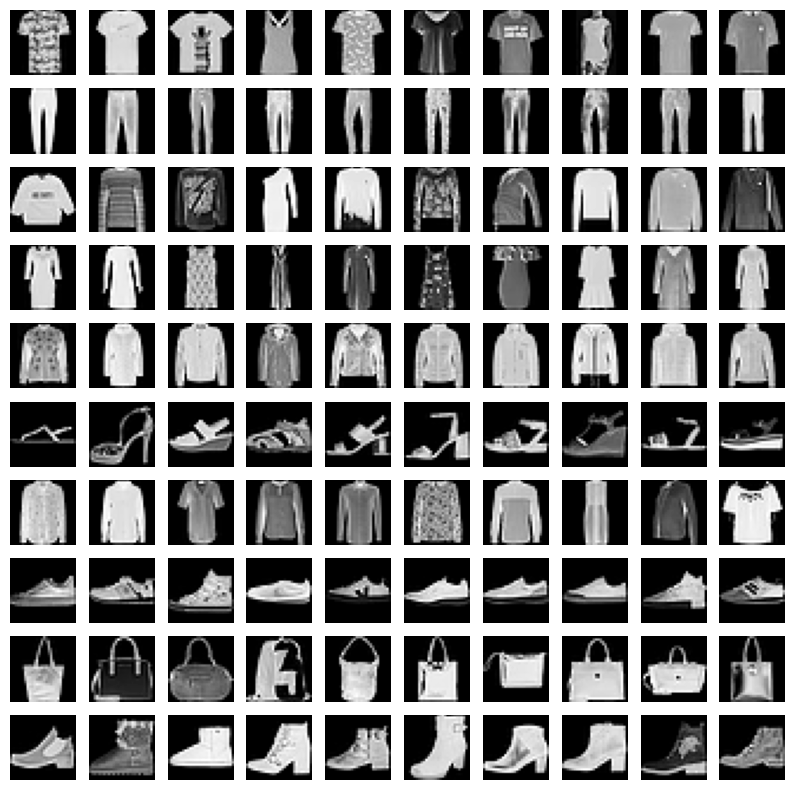

In [8]:
# Reshape the features to 28x28 images
X_train_reshaped = X_train.values.reshape(-1, 28, 28)

# Create a grid of subplots
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# For each label
for label in range(10):
    # Select the indices of the images of this label
    indices = np.where(y_train == label)[0][:10]

    # For each index
    for i, idx in enumerate(indices):
        # Select the corresponding image
        img = X_train_reshaped[idx]

        # Display the image in the (label, i) subplot
        axes[label, i].imshow(img, cmap='gray')
        axes[label, i].axis('off')

plt.show()

# Normalization

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')  # X_test should be features
X_train /= 255.0
X_test /= 255.0  # X_test should be features

# 이미지 증강

In [10]:
# Reshape the data to 4D (num_samples, height, width, num_channels)
X_train_reshaped = X_train.values.reshape(-1, 28, 28, 1)

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    fill_mode='constant',  # fill points outside the input boundaries with 0
    cval=0  # value used for points outside the input boundaries
)

In [11]:
X_augmented = []
y_augmented = []
# Call datagen.flow() 5 times
for i in range(3):
    for X_batch, y_batch in datagen.flow(X_train_reshaped, y_train, batch_size=X_train_reshaped.shape[0]):
        X_augmented.append(X_batch)
        y_augmented.append(y_batch)
        break

# Convert lists to numpy arrays
X_augmented = np.concatenate(X_augmented)
y_augmented = np.concatenate(y_augmented)
# 이제 X_augmented와 y_augmented는 각각 증강된 이미지 데이터와 해당 레이블을 담고 있습니다.

# Flatten the augmented data
X_augmented_flattened = X_augmented.reshape(X_augmented.shape[0], -1)
# X_augmented_flattened는 이제 2D 배열이며, 각 행은 증강된 이미지를 나타냅니다.

# Flatten the original training data
X_train_flattened = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)

# Concatenate the original and the augmented data
X_all_flattened = np.concatenate([X_train_flattened, X_augmented_flattened])
y_all = np.concatenate([y_train, y_augmented])
# 이제 X_all_flattened와 y_all은 원본 및 증강된 이미지 데이터와 해당 레이블을 모두 담고 있습니다.

# 증강한 이미지 확인

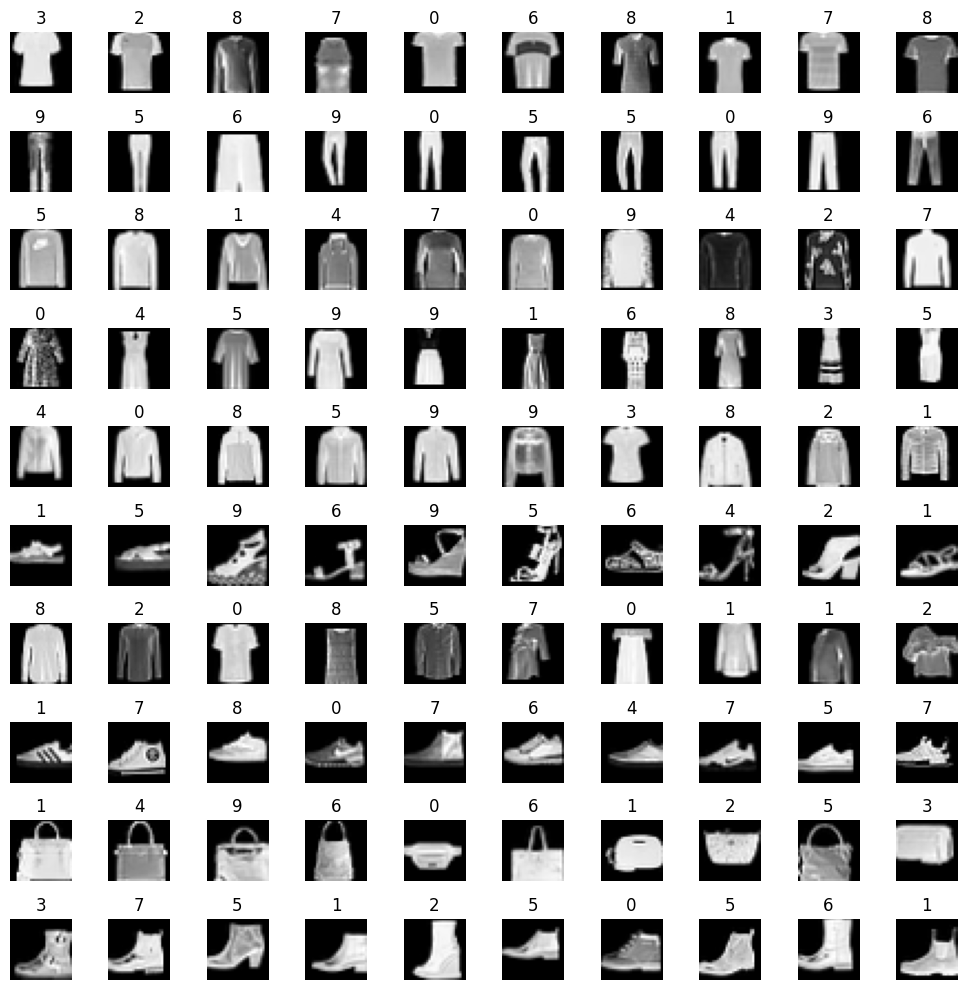

In [12]:
import matplotlib.pyplot as plt

# 라벨별로 10개씩 이미지를 선택
selected_images = []
for label in range(10):
    # 해당 라벨의 이미지만 선택
    selected_indices = (y_augmented == label)
    X_selected = X_augmented[selected_indices]
    # 앞에서부터 10개의 이미지 선택
    selected_images.append(X_selected[:10])

# 선택된 이미지를 numpy 배열로 변환
selected_images = np.concatenate(selected_images)

# 이미지 출력
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # 이미지 출력
    ax.imshow(selected_images[i].reshape(28, 28), cmap='gray')
    # 라벨 출력
    ax.set_title(str(y_augmented[i]))
    # 축 제거
    ax.axis('off')

plt.tight_layout()
plt.show()


# Dimensionality Reduction using PCA

In [13]:
seed = 42

pca = PCA(n_components=150, random_state=seed)
X_train_pca = pca.fit_transform(X_all_flattened)
X_test_pca10 = pca.transform(X_test)  # Apply PCA transform to test data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


# 1차적으로 10개 분류

In [14]:
# SVM 모델 정의
svc1 = SVC(C=4.419450186421157, gamma='scale', kernel='rbf', random_state=seed, probability=True)

# Fit data to model
svc1.fit(X_train_pca, y_all)

# Save the model
best_model = svc1

In [15]:
from joblib import dump, load

# 모델을 파일로 저장
dump(best_model, './svm_model_10.joblib')

['drive/MyDrive/Colab Notebooks/svm_model_10.joblib']

In [16]:
from joblib import dump, load
# 파일에서 모델 불러오기
best_model = load('./svm_model_10.joblib')

# 10개 분류 후 그중 확률이 높은 상위 2개를 또 이진분류

In [17]:
# Reshape the data to 4D (num_samples, height, width, num_channels)
X_train_reshaped = X_train.values.reshape(-1, 28, 28, 1)

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    fill_mode='constant',  # fill points outside the input boundaries with 0
    cval=0  # value used for points outside the input boundaries
)

In [18]:
X_augmented = []
y_augmented = []
# Call datagen.flow() 5 times
for i in range(2):
    for X_batch, y_batch in datagen.flow(X_train_reshaped, y_train, batch_size=X_train_reshaped.shape[0]):
        X_augmented.append(X_batch)
        y_augmented.append(y_batch)
        break

# Convert lists to numpy arrays
X_augmented = np.concatenate(X_augmented)
y_augmented = np.concatenate(y_augmented)
# 이제 X_augmented와 y_augmented는 각각 증강된 이미지 데이터와 해당 레이블을 담고 있습니다.

# Flatten the augmented data
X_augmented_flattened = X_augmented.reshape(X_augmented.shape[0], -1)
# X_augmented_flattened는 이제 2D 배열이며, 각 행은 증강된 이미지를 나타냅니다.

# Flatten the original training data
X_train_flattened = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)

# Concatenate the original and the augmented data
X_all_flattened = np.concatenate([X_train_flattened, X_augmented_flattened])
y_all = np.concatenate([y_train, y_augmented])
# 이제 X_all_flattened와 y_all은 원본 및 증강된 이미지 데이터와 해당 레이블을 모두 담고 있습니다.

In [19]:
seed = 42

pca = PCA(n_components=150, random_state=seed)
X_train_pca = pca.fit_transform(X_all_flattened)
X_test_pca2 = pca.transform(X_test)  # Apply PCA transform to test data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [20]:
from itertools import combinations
import pickle

# 모든 가능한 쌍을 생성
pairs = list(combinations(range(10), 2))

# 각 쌍에 대한 모델을 저장할 딕셔너리
pair_models = {}

# 각 쌍에 대해 학습
cnt = 1
for pair in pairs:
    # 해당 쌍의 데이터만 선택
    print(pair, cnt)
    selected_train_indices = (y_all == pair[0]) | (y_all == pair[1])
    X_train_pair = X_train_pca[selected_train_indices]
    y_train_pair = y_all[selected_train_indices]

    # 해당 쌍을 분류하는 SVM 모델 정의
    svc_pair = SVC(C=4.419450186421157, gamma='scale', kernel='rbf', random_state=seed, probability=True)

    # Fit data to model
    svc_pair.fit(X_train_pair, y_train_pair)

    # Save the model for the pair
    pair_models[pair] = svc_pair

    # 혹시 모르니 중간중간 저장
    if cnt % 10 == 0:
        with open('./svm_models_2.pkl', 'wb') as f:
            pickle.dump(pair_models, f)
    cnt += 1

(0, 1) 1
(0, 2) 2
(0, 3) 3
(0, 4) 4
(0, 5) 5
(0, 6) 6
(0, 7) 7
(0, 8) 8
(0, 9) 9
(1, 2) 10
(1, 3) 11
(1, 4) 12
(1, 5) 13
(1, 6) 14
(1, 7) 15
(1, 8) 16
(1, 9) 17
(2, 3) 18
(2, 4) 19
(2, 5) 20
(2, 6) 21
(2, 7) 22
(2, 8) 23
(2, 9) 24
(3, 4) 25
(3, 5) 26
(3, 6) 27
(3, 7) 28
(3, 8) 29
(3, 9) 30
(4, 5) 31
(4, 6) 32
(4, 7) 33
(4, 8) 34
(4, 9) 35
(5, 6) 36
(5, 7) 37
(5, 8) 38
(5, 9) 39
(6, 7) 40
(6, 8) 41
(6, 9) 42
(7, 8) 43
(7, 9) 44
(8, 9) 45


In [21]:
import pickle

# 'pair_models' 딕셔너리를 파일로 저장
with open('./svm_models_2.pkl', 'wb') as f:
    pickle.dump(pair_models, f)

In [22]:
# Make predictions on the test data (probability)
y_test_proba = best_model.predict_proba(X_test_pca10)  # Predict with PCA transformed test data

# Get the indices of the top 2 predictions
top2_pred_indices = np.argsort(-y_test_proba, axis=1)[:, :2]

# Print the top 2 predicted labels for the first 10 samples
for i in range(10):
    print(f"Sample {i+1} top 2 predicted labels: {top2_pred_indices[i]}")

Sample 1 top 2 predicted labels: [5 9]
Sample 2 top 2 predicted labels: [2 4]
Sample 3 top 2 predicted labels: [0 1]
Sample 4 top 2 predicted labels: [1 5]
Sample 5 top 2 predicted labels: [7 9]
Sample 6 top 2 predicted labels: [1 4]
Sample 7 top 2 predicted labels: [0 6]
Sample 8 top 2 predicted labels: [8 2]
Sample 9 top 2 predicted labels: [9 8]
Sample 10 top 2 predicted labels: [0 1]


In [ ]:
# 최종 예측결과를 저장할 배열
test_pred_final = np.zeros(len(X_test))

# 각 샘플에 대해 상위 2개의 라벨을 뽑고, 이 라벨 쌍에 해당하는 SVM 모델을 사용하여 예측
for i in range(len(X_test)):
    top2_labels = tuple(sorted(top2_pred_indices[i]))
    model = pair_models[top2_labels]
    test_pred_final[i] = model.predict([X_test_pca2[i]])[0]

# 성능 평가

In [ ]:
# 최종 예측결과를 int형으로 변환
test_pred_final = test_pred_final.astype(int)

# 파일에 쓰기
with open('./testResult(나반4조).txt', 'w') as f:
    for i in range(len(test_pred_final)):
        f.write(f"{str(i).zfill(5)} {test_pred_final[i]}\n")